# **Similarity between two images**

## **Import**

In [432]:
!pip install keras
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install sklearn

In [433]:
# Import libraries and modules
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Resizing
from tensorflow.keras import layers
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

## **Dataset**

### Utility functions

In [434]:
def normalize_pixels(image):
    """normalize pixels to be between 0 and 1"""

	# convert from integers to floats
    image_norm = image.astype('float32')
	# normalize to range -1 and 1
    image_norm = (image_norm - 127.5) / 127.5

	# return normalized images
    return image_norm

def de_normalize_pixels(image, _from = 0, _to = 1):
    """de-normalize pixels to be between 0 and 255"""

    # Normalize between 0 and 1
    image_de_norm = (image * 127.5) + 127.5

    # Normalize between 0 and 1
    image_de_norm = image_de_norm/255 

    # Normalize between _from and _to
    image_de_norm = (image_de_norm * (_to - _from)) + _from
    
    return image_de_norm

def load_image(path):
    """load image from path and convert to array"""

    img = load_img(path, target_size=(224, 224), interpolation='bilinear')
    x = img_to_array(img)
    x = normalize_pixels(x)
    x = np.expand_dims(x, axis=0)
    return x

def unison_shuffled_copies(a, b):
    """shuffle two arrays in unison"""

    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

test_image_1 = load_image(r'./data/dataset/all_souls/all_souls_000002.jpg')
test_image_1_de = de_normalize_pixels(test_image_1, 0, 255)
print(np.min(test_image_1))
print(np.max(test_image_1))
print(np.min(test_image_1_de))
print(np.max(test_image_1_de))


-1.0
1.0
0.0
255.0


### Load Dataset

In [435]:
# Variables

DATA_PATH = './data/dataset'
DATA_TRAIN_SPLIT = 0.8
DATA_VALIDATION_SPLIT = 0.1
# The TEST split will be the remaining of the two splits

#amount_of_positive_pairs_per_class = 50

In [436]:
# Load images into arrays
import pathlib

data_dir = pathlib.Path(DATA_PATH)

image_count = len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.jpeg')) + list(data_dir.glob('*/*.png')))
print("Total amount of images: " + str(image_count))

folders = [x for x in data_dir.iterdir() if x.is_dir()]

img_array_data = []

for i, folder in enumerate(folders):
    img_array_data.append([])

    for j, img in enumerate(folder.iterdir()):
        img_array_data[i].append(load_image(img))

Total amount of images: 555


### Create image pairs

In [437]:
data = []
labels = []

# Create image pairs
def create_image_pairs(images):
    for i, array in enumerate(images):
        for j in range(len(array)):
            # True
            data.append([
                images[i][j], 
                images[i][np.random.randint(0, len(images[i]) - 1)]])
            labels.append(1)

            x_1 = np.random.randint(0, len(images) - 1)
            x_2 = np.random.randint(0, len(images[x_1]) - 1)

            # False
            data.append([
                images[i][j], 
                images[x_1][x_2]])
            labels.append(0)

create_image_pairs(img_array_data)

data = np.array(data)
labels = np.array(labels)

In [438]:
# Shuffle Dataset
data, labels = unison_shuffled_copies(data, labels)

show_amount = 10
print(data[:show_amount])
print(labels[:show_amount])

[[[[[[ 0.14509805  0.7176471   0.99215686]
     [ 0.13725491  0.7254902   0.99215686]
     [ 0.20784314  0.7411765   0.99215686]
     ...
     [ 0.70980394  0.9764706   0.99215686]
     [ 0.70980394  0.9764706   0.99215686]
     [ 0.7019608   0.9764706   0.99215686]]

    [[ 0.27058825  0.77254903  0.99215686]
     [ 0.24705882  0.7647059   0.99215686]
     [ 0.3254902   0.79607844  0.99215686]
     ...
     [ 0.70980394  0.99215686  0.99215686]
     [ 0.70980394  0.9843137   0.99215686]
     [ 0.7019608   0.9843137   0.99215686]]

    [[ 0.48235294  0.8745098   0.99215686]
     [ 0.44313726  0.8509804   1.        ]
     [ 0.49019608  0.8745098   0.99215686]
     ...
     [ 0.7254902   0.99215686  1.        ]
     [ 0.7254902   0.99215686  1.        ]
     [ 0.7176471   0.99215686  1.        ]]

    ...

    [[-0.62352943 -0.5764706  -0.56078434]
     [-0.4745098  -0.49019608 -0.4745098 ]
     [-0.43529412 -0.45882353 -0.4509804 ]
     ...
     [-0.69411767 -0.4117647  -0.73333335]
   

In [439]:
# Split data into train, validation, and test

train_split = int(DATA_TRAIN_SPLIT * len(data))
validation_split = train_split+int(DATA_VALIDATION_SPLIT * len(data))

print("TRAIN SPLIT: " + "0 - " + str(train_split) + " | " + str(train_split) + " | " + str(DATA_TRAIN_SPLIT*100) + '%')
print("VALIDATION SPLIT: " + str(train_split) + " - " + str(validation_split) + " | " + str(validation_split-train_split) + " | " + str(DATA_VALIDATION_SPLIT*100) + '%')
print("TEST SPLIT: " + str(validation_split) + " - " + str(len(data)) + " | " + str(len(data) - validation_split) + " | " + str(100 - DATA_TRAIN_SPLIT*100 - DATA_VALIDATION_SPLIT*100) + '%')

data_train = data[0:train_split]
data_validation = data[train_split:validation_split]
data_test = data[validation_split:]

labels_train = labels[0:train_split]
labels_validation = labels[train_split:validation_split]
labels_test = labels[validation_split:]

print("---")
print("Training Data Shape: " + str(data_train.shape))
print("Validation Data Shape: " + str(data_validation.shape))
print("Test Data Shape: " + str(data_test.shape))
print("---")
print("Training Labels Shape: " + str(labels_train.shape))
print("Validation Labels Shape: " + str(labels_validation.shape))
print("Test Labels Shape: " + str(labels_test.shape))

TRAIN SPLIT: 0 - 888 | 888 | 80.0%
VALIDATION SPLIT: 888 - 999 | 111 | 10.0%
TEST SPLIT: 999 - 1110 | 111 | 10.0%
---
Training Data Shape: (888, 2, 1, 224, 224, 3)
Validation Data Shape: (111, 2, 1, 224, 224, 3)
Test Data Shape: (111, 2, 1, 224, 224, 3)
---
Training Labels Shape: (888,)
Validation Labels Shape: (111,)
Test Labels Shape: (111,)


In [440]:
class FeatureExtractor:
    """Class that constructs the Siamese Net for training."""

    def __init__(self):
        """Inits SiameseNetwork with the provided values for the attributes."""

        self.input_shape = (224, 224, 3)  # Size of images
        self.model = []
        self._construct_siamese_architecture()

    def _construct_siamese_architecture(self):
        """ Constructs the siamese architecture and stores it in the class"""

        # Let's define the cnn architecture

        convolutional_net = Sequential()

        base_model = MobileNetV2(input_shape=(self.input_shape), include_top = False, weights='imagenet')
        base_model.trainable = False
        convolutional_net.add(base_model)

        convolutional_net.add(GlobalAveragePooling2D())

        convolutional_net.summary()

        # Now the pairs of images
        input_image_1 = Input(self.input_shape)
        input_image_2 = Input(self.input_shape)

        encoded_image_1 = convolutional_net(input_image_1)
        encoded_image_2 = convolutional_net(input_image_2)

        # L1 distance layer between the two encoded outputs
        # One could use Subtract from Keras, but we want the absolute value
        l1_distance_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
        l1_distance = l1_distance_layer([encoded_image_1, encoded_image_2])

        # Same class or not prediction
        self.model = Model(inputs=[input_image_1, input_image_2], outputs=l1_distance)

        self.model.summary()

feature_extractor = FeatureExtractor()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_18  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_147 (InputLayer)         [(None, 224, 224, 3  0           []                        

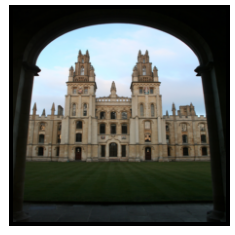

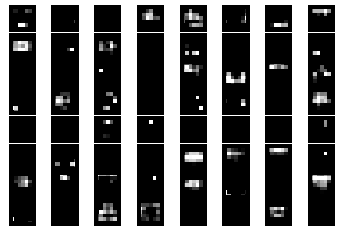

In [441]:
test_image_1 = load_image(r'./data/dataset/all_souls/all_souls_000002.jpg')

_base_model = MobileNetV2(input_shape=(224,224,3), include_top = False, weights='imagenet')
_base_model.trainable = False

feature_maps_1 = _base_model.predict(test_image_1)

def visualize_feature_maps(feature_maps):
	square = 8
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	plt.show()

def visualize_image(image_vector):
	"""
	Visualize the image vector
	"""
	ax = plt.subplot(1, 1, 1)
	ax.set_xticks([])
	ax.set_yticks([])
	plt.imshow(np.reshape(de_normalize_pixels(image_vector), (224, 224, 3)))
	plt.show()

visualize_image(test_image_1)
visualize_feature_maps(feature_maps_1)


In [442]:
# Prepare distance using feature extraction model
distance_data_train = feature_extractor.model.predict([data_train[:, 0, 0], data_train[:, 1, 0]])
distance_label_train = labels_train

distance_data_validation = feature_extractor.model.predict([data_validation[:, 0, 0], data_validation[:, 1, 0]])
distance_label_validation = labels_validation

distance_data_test = feature_extractor.model.predict([data_test[:, 0, 0], data_test[:, 1, 0]])
distance_label_test = labels_test

print(distance_label_train.shape)

print(distance_data_train.shape)

(888,)
(888, 1280)


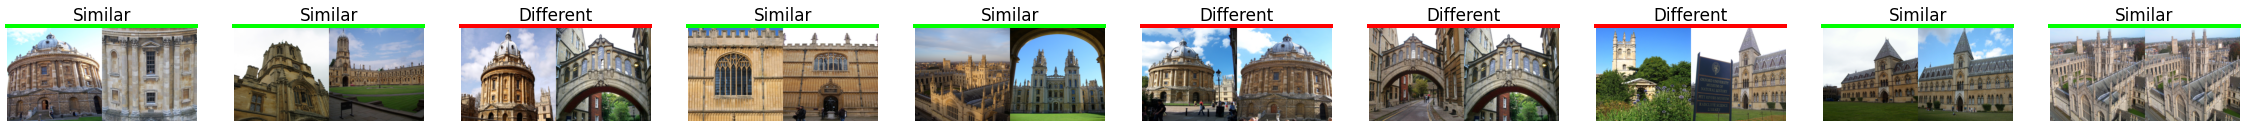

In [443]:
def visualize(pairs, labels, to_show=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    true_color = '#00ff00'
    false_color = '#ff0000'
    scale = 2
    font_size = 14

    # Plot the images
    fig, axes = plt.subplots(1, to_show, figsize=(to_show*2*scale, 1*scale))
    plt.rcParams.update({'font.size': font_size})

    for i in range(to_show):
        axes[i].imshow((tf.concat([de_normalize_pixels(pairs[i, 0, 0]), de_normalize_pixels(pairs[i, 1, 0])], axis=1)), cmap='gray')

        status = "N/A"
        color = '#000000'
        if labels[i] == 1: 
            status = "Similar"
            color = true_color
        if labels[i] == 0: 
            status = "Different"
            color = false_color

        axes[i].set_xticks([])
        axes[i].set_yticks([])

        axes[i].spines['top'].set_visible(True)
        axes[i].spines['top'].set_color(color)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)

        if test:
            axes[i].set_title("{}\nPred: {:.5f}".format(status, predictions[i][0]))
        else:
            axes[i].set_title("{}".format(status))

    plt.show()

visualize(data_train, labels_train, to_show=10)

## **Model**

### Define and Train Model

In [444]:
# NO LAMBDA

class SiameseNetwork:
    """Class that constructs the Siamese Net for training."""

    def __init__(self, learning_rate, decay_rate, input_shape = (224, 224, 3)):
        """Inits SiameseNetwork with the provided values for the attributes."""

        self.input_shape = input_shape  # Size of images
        self.model = []
        self.history = None
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self._construct_siamese_architecture()

    def _construct_siamese_architecture(self):
        """ Constructs the siamese architecture and stores it in the class"""

        # Let's define the cnn architecture

        convolutional_net = Sequential()

        base_model = MobileNetV2(input_shape=(self.input_shape), include_top = False, weights='imagenet')
        base_model.trainable = False
        convolutional_net.add(base_model)

        convolutional_net.add(GlobalAveragePooling2D())

        convolutional_net.summary()

        # Now the pairs of images
        input_image_1 = Input(self.input_shape)
        input_image_2 = Input(self.input_shape)

        encoded_image_1 = convolutional_net(input_image_1)
        encoded_image_2 = convolutional_net(input_image_2)

        self.model = Model(inputs=[input_image_1, input_image_2], outputs=[encoded_image_1, encoded_image_2])

        # Define the optimizer and compile the model
        opt = Adam(learning_rate=self.learning_rate, decay=self.decay_rate)

        self.model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

    def train(self, data_train, labels_train, data_validation, labels_validation, epochs, batch_size, save_model_path):
        """Trains the siamese network

        Args:
            data_train: training data
            labels_train: training labels
            data_validation: validation data
            labels_validation: validation labels
            epochs: number of epochs to train
            batch_size: batch size for training
            save_model_path: path to save the model
        """

        # Train the model
        self.history = self.model.fit([data_train[:, 0, 0], data_train[:, 1, 0]], labels_train,
            validation_data=([data_validation[:, 0, 0], data_validation[:, 1, 0]], labels_validation),
            epochs=epochs, batch_size=batch_size)

    def save(self, save_model_path):
        """Saves the model to the provided path"""

        # Save the model
        self.model.save(save_model_path)

siamese_network = SiameseNetwork(learning_rate = 0.0003, decay_rate = 1e-6)
siamese_network.model.summary()
# siamese_network.train(data_train, labels_train, data_validation, labels_validation, epochs = 8, batch_size = 32, save_model_path = './models/siamese_model.h5')

siamese_network.save('./models/siamese_model_1.h5')


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_19  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_151 (InputLayer)         [(None, 224, 224, 3  0           []                        

In [445]:
class DenseModel:
    """Class that constructs the Siamese Net for training."""

    def __init__(self, learning_rate, decay_rate, input_shape = (1280)):
        """Inits SiameseNetwork with the provided values for the attributes."""

        self.input_shape = input_shape  # Size of images
        self.model = []
        self.history = None
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.create_model()

    def create_model(self):
        """ Constructs the siamese architecture and stores it in the class"""

        input_layer = Input(self.input_shape)

        
        dense_layer = Dense(512, activation='relu')(input_layer)
        dense_layer = Dense(256, activation='relu')(dense_layer)
        dense_layer = Dense(128, activation='relu')(dense_layer)
        dense_layer = Dense(1, activation='sigmoid')(dense_layer)

        self.model = Model(inputs=input_layer, outputs=dense_layer)

        self.model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=self.learning_rate, decay=self.decay_rate), metrics=['acc'])

    def train(self, distance_data_train, distance_label_train, distance_data_validation, distance_label_validation, epochs, batch_size, save_model_path):
        """Trains the siamese network

        Args:
            data_train: training data
            labels_train: training labels
            data_validation: validation data
            labels_validation: validation labels
            epochs: number of epochs to train
            batch_size: batch size for training
            save_model_path: path to save the model
        """

        # Train the model
        self.history = self.model.fit(distance_data_train, distance_label_train,
            validation_data=(distance_data_validation, distance_label_validation),
            epochs=epochs, batch_size=batch_size)


dense_model = DenseModel(learning_rate = 0.0001, decay_rate = 1e-6)
dense_model.train(distance_data_train, distance_label_train, distance_data_validation, distance_label_validation, epochs = 12, batch_size = 32, save_model_path = './models/dense_model.h5')
dense_model.model.summary()
# siamese_network.save(save_model_path = './models/feature_extractor_model.h5')

Epoch 1/12
28/28 [==============================] - 2s 34ms/step - loss: 0.6716 - acc: 0.5788 - val_loss: 0.6571 - val_acc: 0.5586
Epoch 2/12
28/28 [==============================] - 0s 14ms/step - loss: 0.5637 - acc: 0.7252 - val_loss: 0.6340 - val_acc: 0.6937
Epoch 3/12
28/28 [==============================] - 0s 11ms/step - loss: 0.4962 - acc: 0.7984 - val_loss: 0.6121 - val_acc: 0.6396
Epoch 4/12
28/28 [==============================] - 0s 11ms/step - loss: 0.4245 - acc: 0.8491 - val_loss: 0.5881 - val_acc: 0.7117
Epoch 5/12
28/28 [==============================] - 0s 10ms/step - loss: 0.3598 - acc: 0.8874 - val_loss: 0.6168 - val_acc: 0.6667
Epoch 6/12
28/28 [==============================] - 0s 12ms/step - loss: 0.3049 - acc: 0.9110 - val_loss: 0.5852 - val_acc: 0.6847
Epoch 7/12
28/28 [==============================] - 0s 10ms/step - loss: 0.2439 - acc: 0.9437 - val_loss: 0.5786 - val_acc: 0.6937
Epoch 8/12
28/28 [==============================] - 0s 12ms/step - loss: 0.2080 - a

In [446]:
# Manual Test

test_image_1 = load_image(r'./data/dataset/all_souls/all_souls_000002.jpg')
test_image_2 = load_image(r'./data/dataset/all_souls/all_souls_000209.jpg')
test_image_3 = load_image(r'./test_image_3.png')

print("very similar: " + str(dense_model.model.predict(feature_extractor.model.predict([test_image_1, test_image_1]))[0]))
print("similar: " + str(dense_model.model.predict(feature_extractor.model.predict([test_image_1, test_image_2]))[0]))
print("not similar: " + str(dense_model.model.predict(feature_extractor.model.predict([test_image_1, test_image_3]))[0]))

very similar: [0.5607453]
similar: [0.6890325]
not similar: [0.9902699]


### Evaluate Model

In [447]:
_, acc = dense_model.model.evaluate(distance_data_test, distance_label_test)
print('%.3f' % (acc))

4/4 [==============================] - 0s 10ms/step - loss: 0.6195 - acc: 0.7387
0.739


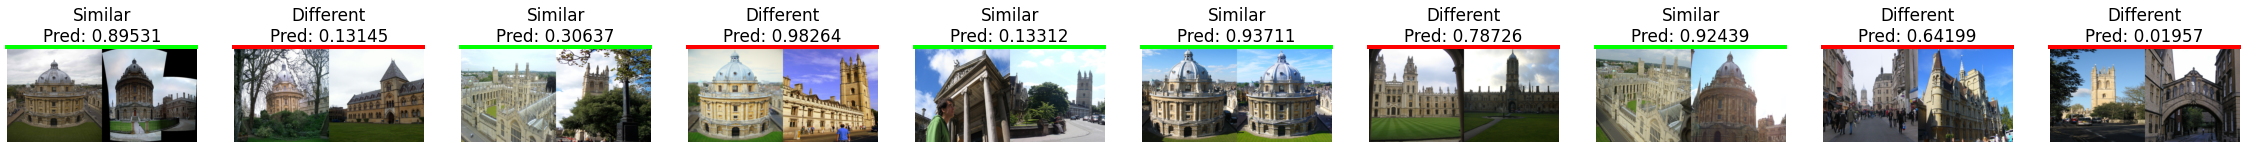

In [448]:
visualize(data_test, labels_test, to_show=10, predictions=dense_model.model.predict(distance_data_test), test=True)

## **Test**

### Plot diagnostic learning curves

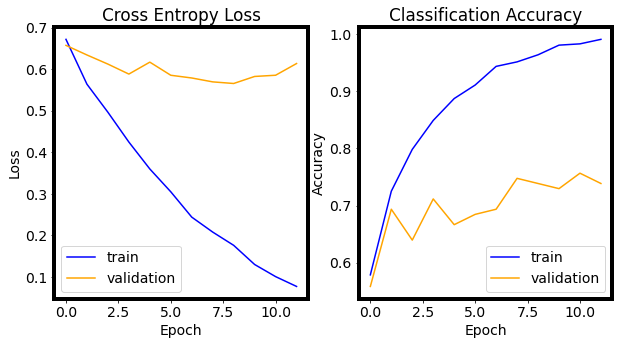

In [449]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].set_title('Cross Entropy Loss')
	ax[0].set_xlabel('Epoch')
	ax[0].set_ylabel('Loss')
	ax[0].plot(history.history['loss'], color='blue', label='train')
	ax[0].plot(history.history['val_loss'], color='orange', label='validation')
	ax[0].legend()

	# plot accuracy
	ax[1].set_title('Classification Accuracy')
	ax[1].set_xlabel('Epoch')
	ax[1].set_ylabel('Accuracy')
	ax[1].plot(history.history['acc'], color='blue', label='train')
	ax[1].plot(history.history['val_acc'], color='orange', label='validation')
	ax[1].legend()
	
	plt.show()

summarize_diagnostics(dense_model.history)

### Kappa Score

In [450]:
# DOESN'T WORK

def calculate_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

pred = dense_model.model.predict(distance_data_test)
pred = np.argmax(pred, axis=1)

kappa = calculate_kappa(distance_label_test, pred)
print("Kappa: ", kappa)

Kappa:  0.0


### Confusion Matrix

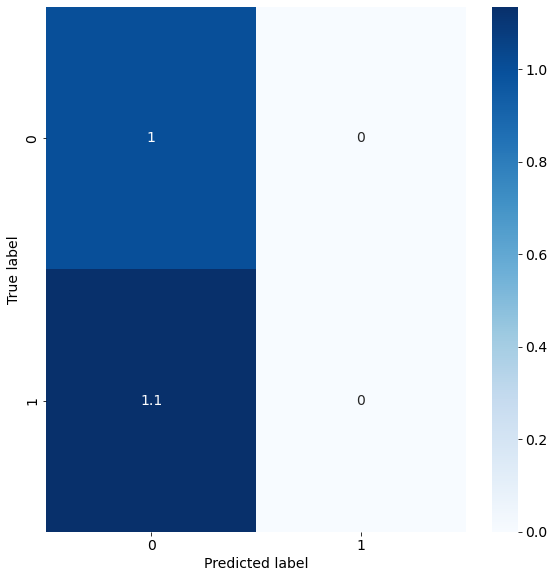

In [451]:
# sns confusion matrix

# !DOESN'T WORK

cm = confusion_matrix(distance_label_test, pred)

cm = cm / cm.astype(float).sum(axis=1) # This line normalizes the calculated confusion matrix

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Convert**

### Export as tensorflow.js model

In [452]:
# !tensorflowjs_converter \
#     --input_format=keras \
#     --weight_shard_size_bytes 1073741824 \
#     ./models/siamese_model_1.h5 \
#     ./models/tfjs_1

In [453]:
shard_size_in_mb = 1024*1024*1024
print(shard_size_in_mb)

1073741824


### TF Lite Model

In [454]:
# model=tf.keras.models.load_model('./model/similarity_model.h5')
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.experimental_new_converter = True
# tflite_model = converter.convert()
# open("converted_model.tflite", "wb").write(tflite_model)